# Loading Pre-Trained Models

## Description

In this tutorial, we will use the pre-trained `squeezenet` model from the [ModelZoo](https://github.com/caffe2/caffe2/wiki/Model-Zoo) to classify our own images. As input, we will provide the path (or URL) to an image we want to classify. It will also be helpful to know the [ImageNet object code](https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes) for the image so we can verify our results. The 'object code' is nothing more than the integer label for the class used during training, for example "985" is the code for the class "daisy". Note, although we are using squeezenet here, this tutorial serves as a somewhat universal method for running inference on pretrained models.

If you came from the [Image Pre-Processing Tutorial](https://caffe2.ai/docs/tutorial-image-pre-processing.html), you will see that we are using rescale and crop functions to prep the image, as well as reformatting the image to be CHW, BGR, and finally NCHW. We also correct for the image mean by either using the calculated mean from a provided npy file, or statically removing 128 as a placeholder average.

Hopefully, you will find that loading pre-trained models is simple and syntactically concise. From a high level, these are the three required steps for running inference on a pretrained model:

1. Read the init and predict protobuf (.pb) files of the pretrained model

        with open("init_net.pb") as f:
            init_net = f.read()
        with open("predict_net.pb") as f:
            predict_net = f.read()        

2. Initialize a Predictor in your workspace with the blobs from the protobufs

        p = workspace.Predictor(init_net, predict_net)

3. Run the net on some data and get the (softmax) results!

        results = p.run({'data': img})

Note, assuming the last layer of the network is a softmax layer, the results come back as a multidimensional array of probabilities with length equal to the number of classes that the model was trained on. The probabilities may be indexed by the object code (integer type), so if you know the object code you can index the results array at that index to view the network's confidence that the input image is of that class.

**Model Download Options**

Although we will use `squeezenet` here, you can check out the [Model Zoo for pre-trained models](https://github.com/caffe2/caffe2/wiki/Model-Zoo) to browse/download a variety of pretrained models, or you can use Caffe2's `caffe2.python.models.download` module to easily acquire pre-trained models from [Github caffe2/models](http://github.com/caffe2/models). 

For our purposes, we will use the `models.download` module to download `squeezenet` into the `/caffe2/python/models` folder of our local Caffe2 installation with the following command:

```
python -m caffe2.python.models.download -i squeezenet
```

If the above download worked then you should have a directory named squeezenet in your `/caffe2/python/models` folder that contains `init_net.pb` and `predict_net.pb`. Note, if you do not use the `-i` flag, the model will be downloaded to your CWD, however it will still be a directory named squeezenet containing two protobuf files. Alternatively, if you wish to download all of the models, you can clone the entire repo using: 

```
git clone https://github.com/caffe2/models
```

## Code 

Before we start, lets take care of the required imports.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace, models
import urllib2
import operator
print("Required modules imported.")

Required modules imported.


### Inputs

Here, we will specify the inputs to be used for this run, including the input image, the model location, the mean file (optional), the required size of the image, and the location of the label mapping file.

In [2]:
# Configuration --- Change to your setup and preferences!
# This directory should contain the models downloaded from the model zoo. To run this 
#   tutorial, make sure there is a 'squeezenet' directory at this location that 
#   contains both the 'init_net.pb' and 'predict_net.pb'
CAFFE_MODELS = "~/caffe2/caffe2/python/models"

# Some sample images you can try, or use any URL to a regular image.
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Whole-Lemon.jpg/1235px-Whole-Lemon.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/7/7b/Orange-Whole-%26-Split.jpg"
# IMAGE_LOCATION = "https://upload.wikimedia.org/wikipedia/commons/a/ac/Pretzel.jpg"
# IMAGE_LOCATION = "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg"
IMAGE_LOCATION = "images/flower.jpg"

# What model are we using?
#    Format below is the model's: <folder, INIT_NET, predict_net, mean, input image size>
#    You can switch 'squeezenet' out with 'bvlc_alexnet', 'bvlc_googlenet' or others that you have downloaded
MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227

# codes - these help decypher the output and source from a list from ImageNet's object codes 
#    to provide an result like "tabby cat" or "lemon" depending on what's in the picture 
#   you submit to the CNN.
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print("Config set!")

Config set!


### Setup paths

With the configs set, we can now load the mean file (if it exists), as well as the predict net and the init net.

In [3]:
# set paths and variables from model choice and prep image
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

# mean can be 128 or custom based on the model
# gives better results to remove the colors found in all of the training images
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    print("No mean file found!")
    mean = 128
else:
    print ("Mean file found!")
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: ", mean)

# some models were trained with different image sizes, this helps you calibrate your image
INPUT_IMAGE_SIZE = MODEL[4]

# make sure all of the files are around...
INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])

# Check to see if the files exist
if not os.path.exists(INIT_NET):
    print("WARNING: " + INIT_NET + " not found!")
else:
    if not os.path.exists(PREDICT_NET):
        print("WARNING: " + PREDICT_NET + " not found!")
    else:
        print("All needed files found!")
        

No mean file found!
mean was set to:  128
All needed files found!


### Image Preprocessing

Now that we have our inputs specified and verified the existance of the input network, we can load the image and pre-processing the image for ingestion into a Caffe2 convolutional neural network! This is a very important step as the trained CNN requires a specifically sized input image whose values are from a particular distribution.

/Users/nateinkawhich/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Original Image Shape:  (751, 1280, 3)
Image Shape after rescaling:  (227, 386, 3)
Image Shape after cropping:  (227, 227, 3)
CHW Image Shape:  (3, 227, 227)
NCHW image (ready to be used as input):  (1, 3, 227, 227)


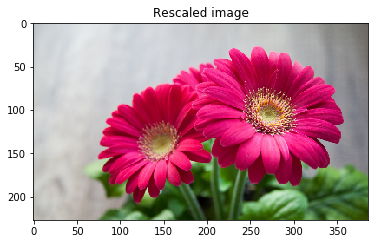

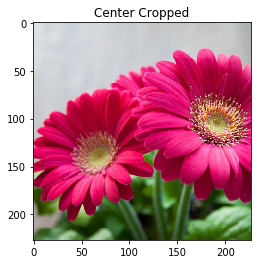

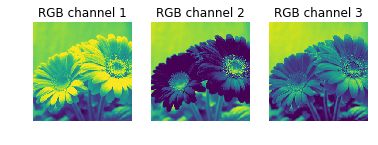

In [4]:
# Function to crop the center cropX x cropY pixels from the input image
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

# Function to rescale the input image to the desired height and/or width. This function will preserve
#   the aspect ratio of the original image while making the image the correct scale so we can retrieve
#   a good center crop. This function is best used with center crop to resize any size input images into
#   specific sized images that our model can use.
def rescale(img, input_height, input_width):
    # Get original aspect ratio
    aspect = img.shape[1]/float(img.shape[0])
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    return imgScaled

# Load the image as a 32-bit float
#    Note: skimage.io.imread returns a HWC ordered RGB image of some size
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
print("Original Image Shape: " , img.shape)

# Rescale the image to comply with our desired input size. This will not make the image 227x227
#    but it will make either the height or width 227 so we can get the ideal center crop.
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image Shape after rescaling: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.title('Rescaled image')

# Crop the center 227x227 pixels of the image so we can feed it to our model
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("Image Shape after cropping: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.title('Center Cropped')

# switch to CHW (HWC --> CHW)
img = img.swapaxes(1, 2).swapaxes(0, 1)
print("CHW Image Shape: " , img.shape)

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR (RGB --> BGR)
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - mean

# add batch size axis which completes the formation of the NCHW shaped input that we want
img = img[np.newaxis, :, :, :].astype(np.float32)

print("NCHW image (ready to be used as input): ", img.shape)

### Prepare the CNN and run the net!

Now that the image is ready to be ingested by the CNN, let's open the protobufs, load them into the workspace, and run the net. 


In [5]:
# Read the contents of the input protobufs into local variables
with open(INIT_NET) as f:
    init_net = f.read()
with open(PREDICT_NET) as f:
    predict_net = f.read()

# Initialize the predictor from the input protobufs
p = workspace.Predictor(init_net, predict_net)

# Run the net and return prediction
results = p.run({'data': img})

# Turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)
print("results shape: ", results.shape)

# Quick way to get the top-1 prediction result
# Squeeze out the unnecessary axis. This returns a 1-D array of length 1000
preds = np.squeeze(results)
# Get the prediction and the confidence by finding the maximum value and index of maximum value in preds array
curr_pred, curr_conf = max(enumerate(preds), key=operator.itemgetter(1))
print("Prediction: ", curr_pred)
print("Confidence: ", curr_conf)

results shape:  (1, 1, 1000, 1, 1)
Prediction:  985
Confidence:  0.98222685


### Process Results

Recall ImageNet is a 1000 class dataset and observe that it is no coincidence that the third axis of results is length 1000. This axis is holding the probability for each category in the pre-trained model. So when you look at the results array at a specific index, the number can be interpreted as the probability that the input belongs to the class corresponding to that index. Now that we have run the predictor and collected the results, we can interpret them by matching them to their corresponding english labels.


In [6]:
# the rest of this is digging through the results 
results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0,2), dtype=object)
arr[:,0] = int(10)
arr[:,1:] = float(10)
for i, r in enumerate(results):
    # imagenet index begins with 1!
    i=i+1
    arr = np.append(arr, np.array([[i,r]]), axis=0)
    if (r > highest):
        highest = r
        index = i 

# top N results
N = 5
topN = sorted(arr, key=lambda x: x[1], reverse=True)[:N]
print("Raw top {} results: {}".format(N,topN))

# Isolate the indexes of the top-N most likely classes
topN_inds = [int(x[0]) for x in topN]
print("Top {} classes in order: {}".format(N,topN_inds))

# Now we can grab the code list and create a class Look Up Table
response = urllib2.urlopen(codes)
class_LUT = []
for line in response:
    code, result = line.partition(":")[::2]
    code = code.strip()
    result = result.replace("'", "")
    if code.isdigit():
        class_LUT.append(result.split(",")[0][1:])
        
# For each of the top-N results, associate the integer result with an actual class
for n in topN:
    print("Model predicts '{}' with {}% confidence".format(class_LUT[int(n[0])],float("{0:.2f}".format(n[1]*100))))


Raw top 5 results: [array([985.0, 0.9822268486022949], dtype=object), array([309.0, 0.011943653225898743], dtype=object), array([946.0, 0.0048101237043738365], dtype=object), array([325.0, 0.0003407070180401206], dtype=object), array([944.0, 0.00023906621208880097], dtype=object)]
Top 5 classes in order: [985, 309, 946, 325, 944]
Model predicts 'daisy' with 98.22% confidence
Model predicts 'bee' with 1.19% confidence
Model predicts 'cardoon' with 0.48% confidence
Model predicts 'sulphur butterfly' with 0.03% confidence
Model predicts 'artichoke' with 0.02% confidence


### Feeding Larger Batches

Above is an example of how to feed one image at a time. We can achieve higher throughput if we feed multiple images at a time in a single batch. Recall, the data fed into the classifier is in 'NCHW' order, so to feed multiple images, we will expand the 'N' axis.

In [7]:
# List of input images to be fed
images = ["images/cowboy-hat.jpg",
            "images/cell-tower.jpg",
            "images/Ducreux.jpg",
            "images/pretzel.jpg",
            "images/orangutan.jpg",
            "images/aircraft-carrier.jpg",
            "images/cat.jpg"]

# Allocate space for the batch of formatted images
NCHW_batch = np.zeros((len(images),3,227,227))
print ("Batch Shape: ",NCHW_batch.shape)

# For each of the images in the list, format it and place it in the batch
for i,curr_img in enumerate(images):
    img = skimage.img_as_float(skimage.io.imread(curr_img)).astype(np.float32)
    img = rescale(img, 227, 227)
    img = crop_center(img, 227, 227)
    img = img.swapaxes(1, 2).swapaxes(0, 1)
    img = img[(2, 1, 0), :, :]
    img = img * 255 - mean
    NCHW_batch[i] = img

print("NCHW image (ready to be used as input): ", NCHW_batch.shape)

# Run the net on the batch
results = p.run([NCHW_batch.astype(np.float32)])

# Turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)

# Squeeze out the unnecessary axis
preds = np.squeeze(results)
print("Squeezed Predictions Shape, with batch size {}: {}".format(len(images),preds.shape))

# Describe the results
for i,pred in enumerate(preds):
    print("Results for: '{}'".format(images[i]))
    # Get the prediction and the confidence by finding the maximum value 
    #   and index of maximum value in preds array
    curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
    print("\tPrediction: ", curr_pred)
    print("\tClass Name: ", class_LUT[int(curr_pred)])
    print("\tConfidence: ", curr_conf)

Batch Shape:  (7, 3, 227, 227)
NCHW image (ready to be used as input):  (7, 3, 227, 227)
Squeezed Predictions Shape, with batch size 7: (7, 1000)
Results for: 'images/cowboy-hat.jpg'
	Prediction:  515
	Class Name:  cowboy hat
	Confidence:  0.85009265
Results for: 'images/cell-tower.jpg'
	Prediction:  645
	Class Name:  maypole
	Confidence:  0.18584323
Results for: 'images/Ducreux.jpg'
	Prediction:  568
	Class Name:  fur coat
	Confidence:  0.1025313
Results for: 'images/pretzel.jpg'
	Prediction:  932
	Class Name:  pretzel
	Confidence:  0.999622
Results for: 'images/orangutan.jpg'
	Prediction:  365
	Class Name:  orangutan
	Confidence:  0.99200517
Results for: 'images/aircraft-carrier.jpg'
	Prediction:  403
	Class Name:  aircraft carrier
	Confidence:  0.9998779
Results for: 'images/cat.jpg'
	Prediction:  281
	Class Name:  tabby
	Confidence:  0.51331687
